In [1]:
import random as r
from math import gcd
import sys
from os import system, name
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Task_Set = pd.read_excel('taskset2_PEDFVD.xlsx')
print(Task_Set.head(5))

   task_id  C_LO  C_HI   T   D  Criticality_level  Release_time  \
0        1     4     2  25  25                  0           NaN   
1        2     6     4  20  20                  0           NaN   
2        3     1     2  10  10                  1           NaN   
3        4     2     3  15  15                  1           NaN   
4        5     2     4  20  20                  1           NaN   

   Virtual_deadline      f  
0               NaN    NaN  
1               NaN    NaN  
2               NaN  0.001  
3               NaN  0.003  
4               NaN  0.001  


In [3]:
# Do the schedulability analysis, check the dataset can be Scheduling by PEDF-VD or not. We will only use clusters
# number M equals 1 here.
'''
input：
    Fs(float): The permitted failure probability of the system.
output:
    schedulability(boolean): Whether the dataset can be scheduling by PEDF-VD
    lamda_max(float): Addition utilization of the system
'''
def Schedulability_analysis(Fs=1e-5):
    schedulability = True;
    u_lo_lo2,u_hi2,u_lo_hi2=0,0,0
    gm, fail0, fail1 =0,1,0
    theta = [] # The additionla utilization of every high critical tasks.
    
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if task['Criticality_level']==1:
            fi = task['f']
            fail0 = fail0 * (1-fi)
            theta.append( (task['C_HI']-task['C_LO']) / task['T'])
            u_hi2 += task['C_HI']/task['T'];
            u_lo_hi2 += task['C_LO']/task['T'];
        elif task['Criticality_level']==0:
            u_lo_lo2 += task['C_LO']/task['T'];
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if task['Criticality_level']==1:
            fi = task['f']
            fail1 = fail1 + fi * fail0/(1-fi)
            
    gm = 1 - fail0 - fail1
    if gm>Fs:
        schedulability = False;
    
    lamda_max = max(theta)
    
    if u_lo_hi2 > (1-lamda_max)*(1-u_lo_lo2):
        schedulability = False;
    
    return schedulability, lamda_max

    
Schedulability_analysis()

(True, 0.1)

In [4]:
# Calculating X：Ratio of Virtural deadline and real deadline 
def calculate_X():
    u_lo_lo,u_hi,u_lo_hi,u_lo_total=0,0,0,0
    
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if task['Criticality_level']==0:
            u_lo_lo += task['C_LO']/task['T'];

        elif task['Criticality_level']==1:
            u_hi += task['C_HI']/task['T'];
            u_lo_hi += task['C_LO']/task['T'];
    
    u_lo_total=u_lo_lo + u_lo_hi;
    #ensuring that EDF-VD successfully schedules all LO-criticality behaviors
    X = u_lo_hi / (1-u_lo_lo);
    #ensuring that EDF-VD successfully schedules all HI -criticality behaviors
    chk = X * u_lo_lo + u_hi;
    if u_hi >1 or u_lo_total >1:
        print("Utilization is larger than 1, can't scheduling!!!");
        return -1;
    elif chk <=1:
        print("X is : %s"%round(X,2));
        return round(X,2);
    else:
        print("X is larger than 1, can't scheduling!!!");
        return -2;
    print("X is : %s"%round(X,2));
x = calculate_X();
print(x)

X is : 0.62
0.62


In [5]:
#Calculating Hyper Periods as LCM
def calculate_LCM():
    lcm = 0;
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if index == 0:
            lcm = int(task['T']);
        else:
            t = int(task['T']);
            lcm = int(lcm * t / gcd(lcm, t));
    return lcm
lcm = calculate_LCM()
print("Hyper Period is: ",lcm)

Hyper Period is:  300


In [6]:
# set VD
for index in range(len(Task_Set)):
    D = Task_Set.loc[index, 'D'];
    if Task_Set.iloc[index]['Criticality_level']==1:
        Task_Set.loc[index,'Virtual_deadline']= D*x;
    elif Task_Set.iloc[index]['Criticality_level']==0:
        Task_Set.loc[index,'Virtual_deadline'] = D;

print(Task_Set.head(5))

   task_id  C_LO  C_HI   T   D  Criticality_level  Release_time  \
0        1     4     2  25  25                  0           NaN   
1        2     6     4  20  20                  0           NaN   
2        3     1     2  10  10                  1           NaN   
3        4     2     3  15  15                  1           NaN   
4        5     2     4  20  20                  1           NaN   

   Virtual_deadline      f  
0              25.0    NaN  
1              20.0    NaN  
2               6.2  0.001  
3               9.3  0.003  
4              12.4  0.001  


In [7]:
# Check if there is any job not completed before ddl. If has , drop it from ready execution queue
'''
input：
    time(int): The time of total clock
    ready_que(pd.Dataframe): The ready executable queue of system
output:
    result(boolean): "True" means has job don't complete on time; "False" means hasn't
    ready_que(pd.Dataframe)
'''
def Check_job(time, ready_que):
    result = False
    if len(ready_que)==0:
        return result,ready_que
    
    for index in range(len(ready_que)):
        job = ready_que.iloc[index]
        if(job['Release_time'] + job['D'] < time):
            ready_que.drop(index)
            result = True
            if job['Criticality_level']==1 :
                print("Danger!!!! A high critical job is not finish on time.")
                print(time, job)
    return result,ready_que


In [8]:
# 判断是否有新的job生成进入可执行队列
# Check whether a new job is generated in this time. If have and move it the executable queue
'''
input：
    time(int): The time of total clock
    mode(int): Mode of system. 1 means high critical mode; 0 means low critical mode
    ready_que(pd.Dataframe): The ready executable queue of system
output:
    ready_que(pd.Dataframe): The ready executable queue of system
'''
def Release_job(time, mode, ready_que):
    if time==0:
        return ready_que;
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if (task['Criticality_level'] == mode) or (task['Criticality_level'] == 1):
            if time % task['T'] == 0:
                a = task.copy();
                a['Release_time'] = int(time);
                a['Job_id'] = int(time / task['T']);
                x = random.random();
                if (task['Criticality_level']==1 and x<=task['f']) or (mode==1): #overrun case
                    a['Remain_execute_time'] = task['C_HI'];
                    a['Execute_time'] = task['C_HI'];
                else:
                    a['Remain_execute_time'] = task['C_LO'];
                    a['Execute_time'] = task['C_LO'];
  
                ready_que = ready_que.append(a, ignore_index=True);
    return ready_que;      

In [9]:
#选择Vd最近的任务执行
# Choose the latest virtual deadline job to execute 1 unit time. If the job time out, then update the criticality mode to hight criticality.
'''
input：
    time(int): The time of total clock
    mode(int): Mode of system. 1 means high critical mode; 0 means low critical mode
    ready_que(pd.Dataframe): The ready executable queue of system
    histort(pd.Dataframe): The execution history for every unit time
    job_num(int): Total finished job of the system
output:
    ready_que(pd.Dataframe)
    mode(int)
    histort(pd.Dataframe)
    job_num(int)
'''
def execut_job(time, mode, ready_que, history, job_num):
    if(len(ready_que)==0):#如果目前准备队列中没有job
        history = history.append({"Time":time, "Mode":mode}, ignore_index=True)
        return ready_que, mode, history, job_num;
    if mode == 0:
        Absolute_VD = ready_que['Release_time'] + ready_que['Virtual_deadline'];
        minidx = Absolute_VD.idxmin();
        ready_que.loc[minidx,'Remain_execute_time'] = ready_que.loc[minidx,'Remain_execute_time'] - 1;
        task_id = ready_que.loc[minidx,'task_id'];
        Job_id = ready_que.loc[minidx,'Job_id'];
        Remain_execute_time = ready_que.loc[minidx,'Remain_execute_time'];
        history = history.append({"Time":time, "Mode":mode, "task_id":task_id, "Job_id":Job_id, 'Remain_execute_time':Remain_execute_time}, ignore_index=True);
        if ready_que.loc[minidx,'Remain_execute_time'] == 0: #如果任务完成
            job_num = job_num + 1;
            if ready_que.loc[minidx,'Execute_time'] > ready_que.loc[minidx,'C_LO']:# 如果执行超时
                mode = 1;
            ready_que = ready_que.drop(minidx);#drop完成的job
    elif mode == 1:
        highjob = ready_que[ready_que['Criticality_level']==1]
        if len(highjob) > 0:
            Absolute_DDL = highjob['Release_time'] + highjob['D'];
        else:
            Absolute_DDL = ready_que['Release_time'] + ready_que['D'];
            
        minidx = Absolute_DDL.idxmin();
        ready_que.loc[minidx,'Remain_execute_time'] = ready_que.loc[minidx,'Remain_execute_time'] - 1;
        task_id = ready_que.loc[minidx,'task_id'];
        Job_id = ready_que.loc[minidx,'Job_id'];
        Remain_execute_time = ready_que.loc[minidx,'Remain_execute_time'];
        history = history.append({"Time":time, "Mode":mode, "task_id":task_id, "Job_id":Job_id, 'Remain_execute_time':Remain_execute_time}, ignore_index=True);
        if ready_que.loc[minidx,'Remain_execute_time'] == 0: #如果任务完成
            job_num = job_num + 1;
            ready_que = ready_que.drop(minidx);
    
    return ready_que, mode, history, job_num;

In [10]:
# Main function of the PEDV-FD schduling
'''
input：
    Totaltime(int): The Totaltime need to schduling
    need_history(Boolean): Print the execution history or not
    Fs(float): The permitted failure probability of the system.
output:
    history(pd.Dataframe): Execution history for every unit time
    job_num(int): Total finished job of the system
'''
def PEDFVD_Schduling(Totaltime, need_history=False, Fs=1e-5):
    mode = 0; #Criticality mode of system
    time = 0; #Time clock of the system
    job_num = 0; #Total finished job of the system
    history = pd.DataFrame(); #History execution record of every unit time
    ready_que = Task_Set.copy(); #Initialize the ready job queue
    ready_que['Release_time'] = int(0);
    ready_que['Remain_execute_time'] = ready_que['C_LO'].astype(np.float64);
    ready_que['Execute_time'] = ready_que['C_LO'];
    ready_que['Job_id'] = int(0);
    
    sche, lamda = Schedulability_analysis(Fs=1e-5);
    if sche==False:
        print("This dataset can't be scheduling by PEDF-VD");
        
    while time < Totaltime: #For every unit time
        #Check if there is any job exceed its DDL
        result, ready_que=Check_job(time, ready_que)
        #Release new job and random its execution time
        ready_que = Release_job(time, mode, ready_que);
        #Choose the latest virtual deadline job to execute 1 unit time
        ready_que, mode, history, job_num = execut_job(time, mode, ready_que, history, job_num)
       
        time = time + 1;
    if need_history:
        print("Execution history for every unit time:");
        print(history);
        print("---------------------------------------");
    #print("Total task finished：",job_num);
    return history, job_num;

In [15]:
import matplotlib.pyplot as plt
# Get the utilization and average finish job numbers for different schduling time.

def test_schduling():
    x = [5, 10, 20, 40, 60, 80, 100]
    utilization = []
    Avg_jobnum = []
    for i in x:
        u_sum = 0;
        a_sum = 0;
        for j in range(3):
            Totaltime = i*lcm;
            history, finished_task = PEDFVD_Schduling(Totaltime, need_history=False, Fs=1e-5)
            not_use_time = pd.isna(history["task_id"])
            u = (Totaltime - len(history[not_use_time])) / Totaltime
            a_jn = finished_task/Totaltime
            u_sum = u_sum + u
            a_sum = a_sum + a_jn
        utilization.append(u_sum/3)
        Avg_jobnum.append(a_sum/3)
        print("Finish",i)
    
    fig, ax = plt.subplots()
    ax.plot(x, utilization, "or:")
    ax.set_ylim(ymin = 0, ymax = 1.0)
    ax.set_title("Utilization of PEDF-VD")
    ax.set_xlabel("Total schduling time")
    ax.set_ylabel("Utilization")
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(x, Avg_jobnum, "og:")
    ax.set_title("Average finish job of PEDF-VD")
    ax.set_xlabel("Total schduling time")
    ax.set_ylabel("Avg jobs per unit time")
    ax.set_ylim(ymin = 0, ymax = 0.4)
    plt.show()
    print("Utilization: ", utilization)
    print("Avg job nums: ", Avg_jobnum)

Finish 5
Finish 10
Finish 20
Finish 40
Finish 60
Finish 80
Finish 100


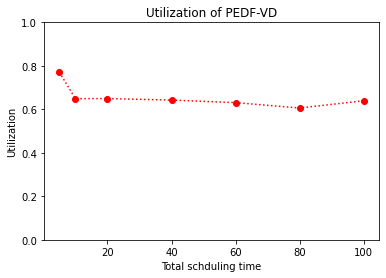

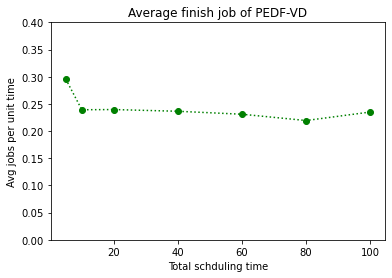

Utilization:  [0.7702222222222223, 0.648888888888889, 0.649611111111111, 0.642638888888889, 0.6308518518518519, 0.6060138888888889, 0.639511111111111]
Avg job nums:  [0.29555555555555557, 0.23922222222222222, 0.2396111111111111, 0.23644444444444443, 0.23098148148148145, 0.21941666666666668, 0.23503333333333334]


In [16]:
test_schduling()